## Topic Detection

In [1]:
import numpy as np 
import pandas as pd 

import nltk
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import gensim
from gensim.utils import simple_preprocess

In [2]:
reviews_df = pd.read_csv('/Users/sudeshgurung/Msc-Data_Analytics/ADTA_with_python/coursework_part_2/Part_2/dataset/amazon_cells_labelled.txt', sep="\t" , names = ['Review', 'Sentiment'])
reviews_df.head()


,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


## Pre-processing the data

In [3]:
reviews_df = reviews_df.astype({'Review': 'string'})
reviews_df.dtypes

Review       string
Sentiment     int64
dtype: object

In [4]:
reviews_df.head()

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
# only the sentence for text pre-processing 
reviews = reviews_df['Review']
reviews[:5]

0    So there is no way for me to plug it in here i...
1                          Good case, Excellent value.
2                               Great for the jawbone.
3    Tied to charger for conversations lasting more...
4                                    The mic is great.
Name: Review, dtype: string

In [6]:
reviews1 = []

for row in reviews: 
    #remove punctuation 
    row = row.translate(str.maketrans('', '', string.punctuation))
    
    #remove digits/numbers 
    row = row.translate(str.maketrans('', '', string.digits))
    
    #change to lowercase 
    row = row.lower()
    
    reviews1.append(row)
reviews1

['so there is no way for me to plug it in here in the us unless i go by a converter',
 'good case excellent value',
 'great for the jawbone',
 'tied to charger for conversations lasting more than  minutesmajor problems',
 'the mic is great',
 'i have to jiggle the plug to get it to line up right to get decent volume',
 'if you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one',
 'if you are razr owneryou must have this',
 'needless to say i wasted my money',
 'what a waste of money and time',
 'and the sound quality is great',
 'he was very impressed when going from the original battery to the extended battery',
 'if the two were seperated by a mere  ft i started to notice excessive static and garbled sound from the headset',
 'very good quality though',
 'the design is very odd as the ear clip is not very comfortable at all',
 'highly recommend for any one who has a blue tooth phone',
 'i advise everyone do not be fooled',
 'so far 

In [7]:
reviews1 = pd.Series(reviews1)
reviews1[:5]

0    so there is no way for me to plug it in here i...
1                            good case excellent value
2                                great for the jawbone
3    tied to charger for conversations lasting more...
4                                     the mic is great
dtype: object

In [8]:
# setting english stopwords
stop_words = set(stopwords.words('English'))

reviews1 = reviews1.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
reviews1[:10]

0                      way plug us unless go converter
1                            good case excellent value
2                                        great jawbone
3    tied charger conversations lasting minutesmajo...
4                                            mic great
5         jiggle plug get line right get decent volume
6    several dozen several hundred contacts imagine...
7                                   razr owneryou must
8                            needless say wasted money
9                                     waste money time
dtype: object

In [9]:
# removing character less than 3
removing_lt_3 = reviews1.apply(lambda x: ' '.join(term for term in x.split() if len(term) > 2))
removing_lt_3

0                              way plug unless converter
1                              good case excellent value
2                                          great jawbone
3      tied charger conversations lasting minutesmajo...
4                                              mic great
                             ...                        
995           screen get smudged easily touches ear face
996                          piece junk lose calls phone
997                                   item match picture
998                 thing disappoint infra red port irda
999                       answer calls unit never worked
Length: 1000, dtype: object

In [10]:
# apply lemmatizing with POS tags 
from nltk.corpus import wordnet 
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(word):
    # Map POS tag to first character Lemmatize() accepts 
    tag = nltk.pos_tag([word])[0][1][0].upper()
#     display(tag)
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN, 
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

# init WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
reviews3 = removing_lt_3.apply(lambda x: ' '.join(lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x.split()))
reviews3[:10] 

0                            way plug unless converter
1                            good case excellent value
2                                        great jawbone
3    tie charger conversation last minutesmajor pro...
4                                            mic great
5         jiggle plug get line right get decent volume
6    several dozen several hundred contact imagine ...
7                                   razr owneryou must
8                               needle say waste money
9                                     waste money time
dtype: object

In [11]:
#putting back preprocessed text and labels 

temp = list(zip(reviews3, reviews_df['Sentiment']))
reviews2 = pd.DataFrame(temp, columns = ['Review', 'Sentiment'])
reviews2

,Review,Sentiment
0,way plug unless converter,0
1,good case excellent value,1
2,great jawbone,1
3,tie charger conversation last minutesmajor pro...,0
4,mic great,1
...,...,...
995,screen get smudge easily touch ear face,0
996,piece junk lose call phone,0
997,item match picture,0
998,thing disappoint infra red port irda,0


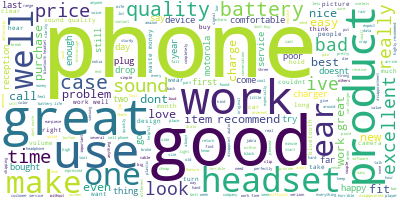

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(reviews2['Review'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Topic detection process

In [13]:
data = reviews2.Review.values.tolist()


In [14]:
data

['way plug unless converter',
 'good case excellent value',
 'great jawbone',
 'tie charger conversation last minutesmajor problem',
 'mic great',
 'jiggle plug get line right get decent volume',
 'several dozen several hundred contact imagine fun send one one',
 'razr owneryou must',
 'needle say waste money',
 'waste money time',
 'sound quality great',
 'impressed go original battery extend battery',
 'two seperated mere start notice excessive static garble sound headset',
 'good quality though',
 'design odd ear clip comfortable',
 'highly recommend one blue tooth phone',
 'advise everyone fool',
 'far good',
 'work great',
 'click place way make wonder long mechanism would last',
 'go motorolas website follow direction could get pair',
 'bought use kindle fire absolutely love',
 'commercial mislead',
 'yet run new battery two bar thats three day without charge',
 'bought mother problem battery',
 'great pocket phone combination',
 'ive own phone month say best mobile phone ive',
 

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

words = list(sent_to_words(data))

In [16]:
print(words[6:7][0][:30])

['several', 'dozen', 'several', 'hundred', 'contact', 'imagine', 'fun', 'send', 'one', 'one']


In [17]:
import gensim.corpora as corpora                      

# Create Dictionary
id2word = corpora.Dictionary(words)  

# Create Corpus
texts = words                                        

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]    

# View
print(corpus[6:7][0][:30])

[(23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 2)]


In [141]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word, num_topics=num_topics, random_state=1, workers=3, passes=50, per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
# pd.DataFrame(lda_model.print_topics())
#doc_lda = lda_model[corpus]

[(0,
  '0.042*"good" + 0.032*"phone" + 0.031*"great" + 0.026*"price" + '
  '0.019*"product" + 0.017*"case" + 0.017*"time" + 0.017*"look" + 0.016*"make" '
  '+ 0.015*"waste"'),
 (1,
  '0.067*"battery" + 0.019*"life" + 0.017*"also" + 0.015*"hold" + 0.015*"long" '
  '+ 0.012*"recommend" + 0.012*"charge" + 0.012*"love" + 0.012*"poor" + '
  '0.010*"phone"'),
 (2,
  '0.028*"work" + 0.020*"item" + 0.019*"great" + 0.017*"phone" + 0.017*"well" '
  '+ 0.016*"use" + 0.013*"product" + 0.013*"new" + 0.013*"month" + '
  '0.011*"get"'),
 (3,
  '0.038*"product" + 0.034*"service" + 0.031*"excellent" + 0.025*"phone" + '
  '0.020*"great" + 0.016*"customer" + 0.015*"get" + 0.011*"use" + 0.011*"bad" '
  '+ 0.011*"price"'),
 (4,
  '0.056*"phone" + 0.022*"problem" + 0.012*"volume" + 0.010*"ear" + '
  '0.010*"like" + 0.009*"also" + 0.009*"try" + 0.009*"impressed" + '
  '0.009*"week" + 0.009*"first"'),
 (5,
  '0.046*"dont" + 0.028*"use" + 0.018*"would" + 0.017*"recommend" + '
  '0.016*"buy" + 0.016*"doesnt" + 

In [142]:
topic_in_doc = list(lda_model.get_document_topics(corpus, minimum_probability=None, minimum_phi_value=None, per_word_topics=False))


In [143]:
topic_in_doc[0][0]

# topic_probability ={}

# for topics in topic_in_doc:
#     for topic in topics: 
#         topic_number = "Topic: "+str(topic[0])
#         topic_probability[topic_number] = topic[1]
   

(0, 0.020001886)

In [144]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.397198712616826

Coherence Score:  0.4552006607402461


In [145]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

lda_topics = lda_model.print_topics()

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
#     print(topic)
    topics.append(preprocess_string(topic[1], filters))




In [150]:
topics_dict = {}
i = 1
for topic in topics: 
    temp = ', '.join(topic)
    topics_dict["Topic-"+str(i)] = temp
    i = i + 1

result = pd.DataFrame(topics_dict.values(), index= topics_dict.keys(), columns= ['Terms'])[:10]

In [151]:
from IPython.display import HTML

HTML(result.to_html())

,Terms
Topic-1,"good, phone, great, price, product, case, time, look, make, waste"
Topic-2,"battery, life, also, hold, long, recommend, charge, love, poor, phone"
Topic-3,"work, item, great, phone, well, use, product, new, month, get"
Topic-4,"product, service, excellent, phone, great, customer, get, use, bad, price"
Topic-5,"phone, problem, volume, ear, like, also, try, impressed, week, first"
Topic-6,"dont, use, would, recommend, buy, doesnt, enough, case, product, money"
Topic-7,"phone, best, charger, bad, well, ive, ever, reception, fit, work"
Topic-8,"phone, like, use, nice, quality, hour, design, great, return, really"
Topic-9,"work, great, quality, good, sound, well, fine, far, like, headset"
Topic-10,"phone, headset, use, comfortable, really, easy, get, bluetooth, ear, day"


In [23]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [149]:
import pyLDAvis.gensim_models
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

LDAvis

/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sudeshgurung/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/sudesh

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.063362 -0.130013       1        1  13.148380
6      0.038310  0.132827       2        1  12.783683
8     -0.201304 -0.015393       3        1  12.133993
9     -0.011255  0.068517       4        1  11.316850
5      0.140512 -0.061212       5        1   9.607923
2     -0.048675  0.050727       6        1   9.357988
4      0.025774  0.094956       7        1   8.765095
3      0.040952 -0.057761       8        1   8.272541
1      0.096452 -0.053612       9        1   7.701037
7     -0.017404 -0.029036      10        1   6.912509, topic_info=         Term       Freq      Total Category  logprob  loglift
70       work  88.000000  88.000000  Default  30.0000  30.0000
41    battery  36.000000  36.000000  Default  29.0000  29.0000
293      dont  24.000000  24.000000  Default  28.0000  28.0000
8       great  77.000000  77.000000  Default  27.0000  27.0000
128   product  44.000000  44.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
564  horrible   1.597583   7.106376  Topic10  -5.4142   1.1793
168   feature   1.597376   7.085120  Topic10  -5.4143   1.1822
160     clear   1.597347  10.081586  Topic10  -5.4143   0.8295
439     cheap   1.597317   7.757368  Topic10  -5.4143   1.0915
156      poor   1.597315  12.291071  Topic10  -5.4143   0.6313

[656 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
892       1  0.851910  ability
544       1  0.258941     able
544       7  0.258941     able
544      10  0.517882     able
1178      7  0.856706   accept
...     ...       ...      ...
139       3  0.225653     year
139       4  0.225653     year
139       7  0.150435     year
139       9  0.150435     year
975       8  0.651262     zero

[1158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 9, 10, 6, 3, 5, 4, 2, 8])

In [152]:
# num_topics_5 = 10

# # Build LDA model
# lda_model_5 = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word, workers=8, num_topics= num_topics_5, random_state=1, iterations = 1000, chunksize=100, passes=10, per_word_topics=True)

# # Print the Keyword in the 5 topics
# pprint(lda_model_5.print_topics())


In [154]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     coherence_values = []
#     perplexity_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word, workers=8, num_topics=num_topics, iterations = 1000, chunksize=100, passes=10, random_state=1,per_word_topics=True)
#         model_list.append(model)
        
#         preplexity = model.log_perplexity(corpus)
#         perplexity_values.append(preplexity)
            
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values, perplexity_values

In [155]:
# model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words, start=2, limit=40, step=1)




In [156]:
# # Show graph
# limit=40; start=2; step=1;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [157]:
# # Print the coherence scores
# for m, cv, pv in zip(x, coherence_values, perplexity_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " preplexity score = ", round(pv, 4))

In [158]:
 
# # Select the model and print the topics 14
# optimal_model = model_list[12]
# print('\nPerplexity: ', optimal_model.log_perplexity(corpus)) 
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics())

In [159]:
# topics_optimal = optimal_model.print_topics(-1)

# my_dict = {'Topic_' + str(i): [token for token, score in optimal_model.show_topic(i)] for i in range(0, len(topics_optimal))}
# my_dict                             

In [162]:
# temp_dict = {}
# for key in my_dict.keys():
# #     print(my_dict[key])
#     temp_dict[key] = [', '.join(my_dict[key])]

# temp_dict

In [53]:
# topics_df_ = pd.DataFrame(temp_dict.values(), index= temp_dict.keys(), columns= ['Terms'])

In [160]:
# from IPython.display import HTML

# HTML(topics_df_.to_html())

In [161]:
# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)

# LDAvis